<a href="https://colab.research.google.com/github/mantle-bearer/FAW-Detection-Capstone/blob/feat%2Fsubmission/Final_Group_U_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FALL ARMYWORM SUPERVISED LEARNING AI DETECTION**

*AN AI CAPSTONE PROJECT*

*BY GROUP U*

## **1.0 INTRODUCTION**

### 1.1 Background
The Fall Armyworm is a major invasive agricultural pest causing significant crop loss globally, with an average of **31% annual maize loss** in Africa. Early and accurate detection is crucial for effective pest management. Participants will design, train, and evaluate a supervised AI model to identify the presence of FAW (larvae, pupae, moths, or infestation signs like damage) from visual input.
The primary goal is to produce a **compact, deployable, and performant AI model** compatible with the **Open Neural Network Exchange (ONNX)** format, enabling easy integration into various real-world applications.

### 1.2 Objectives
1. To apply supervised learning to detect Fall Armyworm from images or videos.

2. To build and train a computer vision model for FAW classification or detection.

3. To optimize the model for accuracy and efficiency in limited computing environments.

4. To prepare the model for deployment by exporting to the ONNX format.

5. To ensure reproducibility through clear documentation of the ML pipeline.


### 1.3 Dataset Overview

The FAW Dataset used in this project was created by combining and refining data from Kaggle and Roboflow sources:

The merged dataset was curated to support supervised image classification for detecting the presence of Fall Armyworm or its damage symptoms.

## **2.0 DATA PREPARATION**

### 2.1 Importation of Libraries

In [ ]:
# Install required tuner
!pip install -q keras-tuner --upgrade

# Uninstall conflicting packages (old / preinstalled versions)
!pip uninstall -y tensorflow tf2onnx onnx protobuf jax jaxlib

In [ ]:
# Install compatible, stable version of tensorflow verified to work with DenseNet121 + ONNX export
!pip install -q tensorflow==2.16.1

In [ ]:
# Install compatible, stable version of tf2onnx verified to work with DenseNet121 + ONNX export
!pip install -q tf2onnx==1.16.1

In [ ]:
# Install compatible, stable version of onnx verified to work with DenseNet121 + ONNX export
!pip install -q onnx==1.16.0

In [ ]:
# Install compatible, stable version of protobuf verified to work with DenseNet121 + ONNX export
!pip install -q protobuf==3.20.3

In [11]:
# Verify environment versions
import tensorflow as tf, tf2onnx, onnx
print("TensorFlow installed version:", tf.__version__)
print("tf2onnx Installed version:", tf2onnx.__version__)
print("ONNX installed version:", onnx.__version__)



# --------------------------------------------------------------
# EXPECTED OUTPUT (if setup completed successfully):
# TensorFlow installed version: 2.16.1
# tf2onnx installed version: 1.16.1
# ONNX installed version: 1.16.0
# --------------------------------------------------------------

TensorFlow installed version: 2.16.1
tf2onnx Installed version: 1.16.1
ONNX installed version: 1.16.0


In [7]:
#Import Libraries

## For data manipulation and managing dataset folders
import pandas as pd, os, shutil
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm

## For ML & Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, average_precision_score
    )

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import (
    MobileNetV2, EfficientNetB0, ResNet50, DenseNet121
    )
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_pre
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_pre
from tensorflow.keras.applications.resnet import preprocess_input as resnet_pre
from tensorflow.keras.applications.densenet import preprocess_input as densenet_pre
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
import tf2onnx
import onnx


### 2.2 Loading FAW Dataset

In [3]:
# Loading dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **3.0 DATA CLEANING**

In [4]:
# Dataset path
base_dir = "/content/drive/My Drive/Colab Notebooks/fall_armyworm"

In [5]:
# Getting subfolders (class names)
classes = sorted(os.listdir(base_dir))
print("Classes found:", classes)

Classes found: ['0', '1']


In [6]:
data = []

# Looping through each class folder
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue  # skip files that aren't folders

    for filename in tqdm(os.listdir(cls_path), desc=f"Checking {cls}"):
        file_path = os.path.join(cls_path, filename)

        try:
            with Image.open(file_path) as img:
                width, height = img.size
                img.verify()  # verifies image integrity
                status = "ok"
        except (UnidentifiedImageError, OSError):
            status = "corrupt"
            width, height = None, None

        # storing info
        data.append({
            "filename": filename,
            "class": cls,
            "path": file_path,
            "width": width,
            "height": height,
            "status": status
        })

Checking 1: 100%|██████████| 1882/1882 [00:28<00:00, 66.94it/s] 


In [7]:
# Creating a DataFrame for all info
df = pd.DataFrame(data)
df.head()

,filename,class,path,width,height,status
0,id_px3z0axgt3mac.jpg,0,/content/drive/My Drive/Colab Notebooks/fall_a...,512,512,ok
1,id_b3mqc7ajzoprh.jpg,0,/content/drive/My Drive/Colab Notebooks/fall_a...,512,512,ok
2,id_aj2y163yhuxh4.jpg,0,/content/drive/My Drive/Colab Notebooks/fall_a...,512,512,ok
3,id_nprlf5w1x4onk.jpg,0,/content/drive/My Drive/Colab Notebooks/fall_a...,512,512,ok
4,id_6vj1e12x3t6ps.jpg,0,/content/drive/My Drive/Colab Notebooks/fall_a...,512,512,ok


In [8]:
# Checking for corrupt or unreadable files
print("Corrupt images:", len(df[df['status'] == 'corrupt']))

Corrupt images: 0


In [9]:
# Showing number of images per class
df[df['status'] == 'ok']['class'].value_counts()

,count
class,
1,1882
0,1107


## **4.0 EXPLORATORY DATA ANALYSIS**

### 4.1 Loading Cleaned Dataset

In [10]:
# Ensuring clean data only
clean_df = df[df["status"] == "ok"].copy().reset_index(drop=True)
print(f"Total Clean Images: {len(clean_df)}")
print(clean_df["class"].value_counts())

Total Clean Images: 2989
class
1    1882
0    1107
Name: count, dtype: int64


### 4.2 Class Distribution

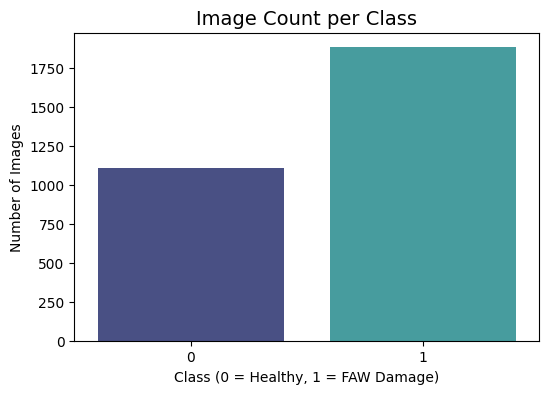

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(data=clean_df, x="class", hue="class", palette="mako", legend=False)
plt.title("Image Count per Class", fontsize=14)
plt.xlabel("Class (0 = Healthy, 1 = FAW Damage)")
plt.ylabel("Number of Images")
plt.show()

### 4.3 Image Dimension Overview

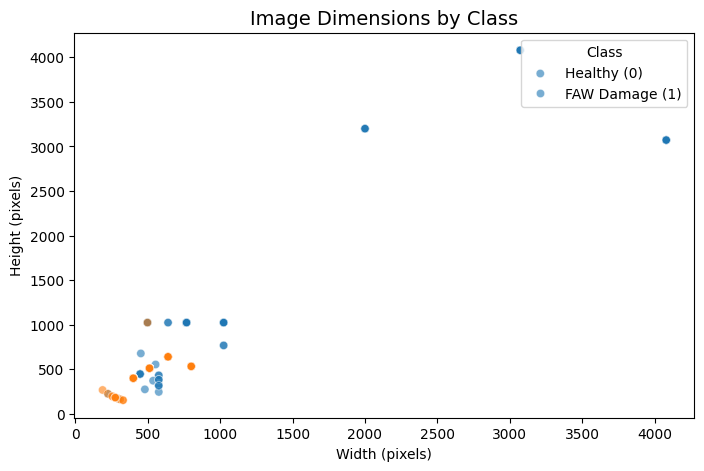

In [12]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=clean_df, x="width", y="height", hue="class", alpha=0.6)
plt.title("Image Dimensions by Class", fontsize=14)
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.legend(title="Class", labels=["Healthy (0)", "FAW Damage (1)"])
plt.show()

### 4.4 Aspect Ratio Distribution

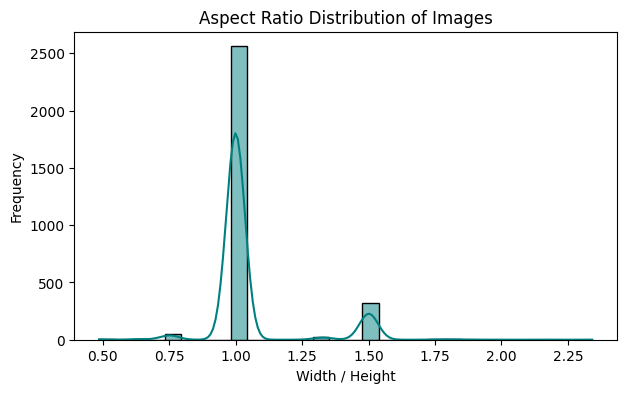

In [13]:
clean_df["aspect_ratio"] = clean_df["width"] / clean_df["height"]

plt.figure(figsize=(7,4))
sns.histplot(clean_df["aspect_ratio"], bins=30, kde=True, color="teal")
plt.title("Aspect Ratio Distribution of Images")
plt.xlabel("Width / Height")
plt.ylabel("Frequency")
plt.show()

### 4.5 Random Image Samples

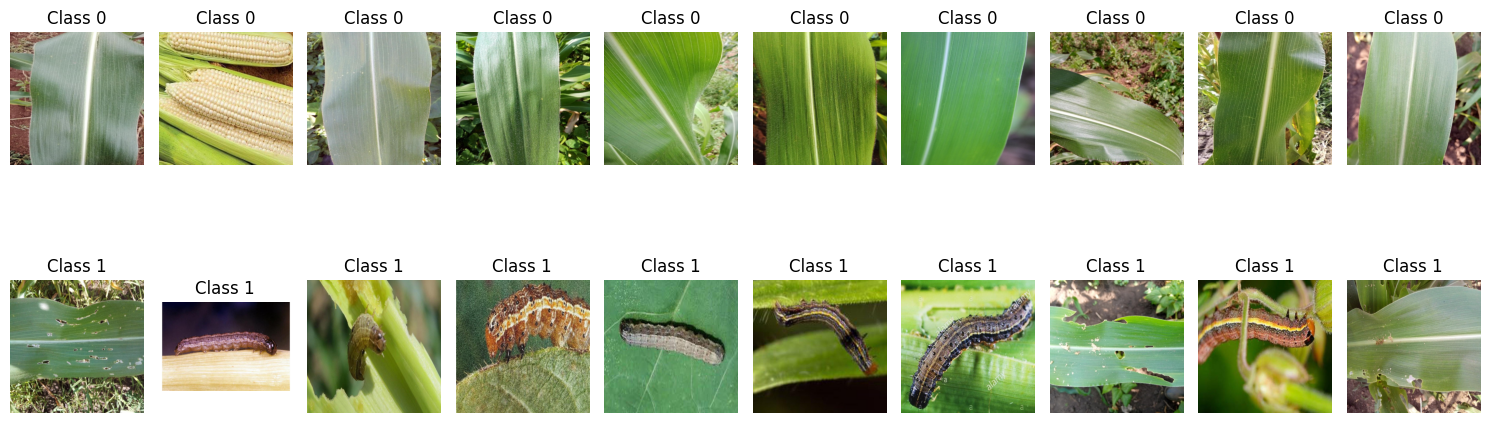

In [14]:
def show_samples(df, samples_per_class=10):
    classes = sorted(df["class"].unique())
    plt.figure(figsize=(15, 6))

    for i, cls in enumerate(classes):
        samples = df[df["class"] == cls].sample(samples_per_class, random_state=42)
        for j, row in enumerate(samples.itertuples()):
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            img = Image.open(row.path)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Class {cls}")
    plt.tight_layout()
    plt.show()

show_samples(clean_df)

### 4.6 Summary of Image Dimensions

In [15]:
summary = clean_df.groupby("class")[["width", "height"]].agg(["mean", "std", "min", "max"]).round(1)
summary

width                   height                  
        mean    std  min   max   mean    std  min   max
class                                                  
0      648.8  657.4  225  4080  666.5  707.6  168  4080
1      610.9  110.6  188   800  565.8   76.0  153  1024

### 4.7 Aspect Ratio by Class

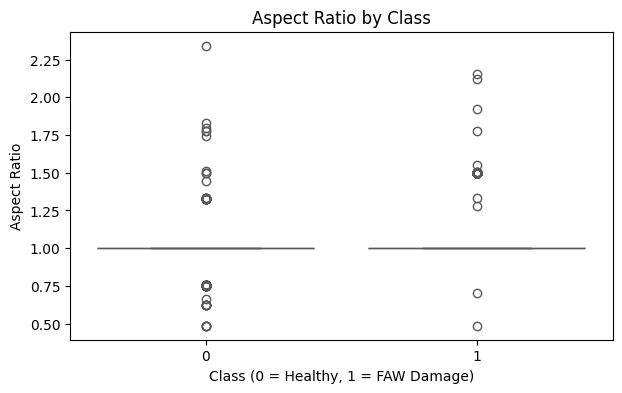

In [16]:
plt.figure(figsize=(7,4))
sns.boxplot(data=clean_df, x="class", y="aspect_ratio", hue="class", palette="Set2", legend=False)
plt.title("Aspect Ratio by Class")
plt.xlabel("Class (0 = Healthy, 1 = FAW Damage)")
plt.ylabel("Aspect Ratio")
plt.show()

## **5.0 DATA PREPROCESSING**

### 5.1 Defining Labels

In [17]:
# Creating DataFrame of image paths and labels
data = []
for label in ["0", "1"]:
    folder = os.path.join(base_dir, label)
    for file in os.listdir(folder):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            data.append((os.path.join(folder, file), int(label)))

df = pd.DataFrame(data, columns=["path", "class"])
print(df.head(), "\n")
print(df["class"].value_counts())

                                                path  class
0  /content/drive/My Drive/Colab Notebooks/fall_a...      0
1  /content/drive/My Drive/Colab Notebooks/fall_a...      0
2  /content/drive/My Drive/Colab Notebooks/fall_a...      0
3  /content/drive/My Drive/Colab Notebooks/fall_a...      0
4  /content/drive/My Drive/Colab Notebooks/fall_a...      0 

class
1    1882
0    1107
Name: count, dtype: int64


### 5.2 Automatic Scan

In [18]:
# Ensuring robust error handling as tf is stricter than matplotlib
def is_image_valid(path):
    try:
        img = Image.open(path)
        img.verify()  # Check integrity
        return True
    except Exception:
        return False

print("Scanning for unreadable images...")
df["is_valid"] = df["path"].apply(is_image_valid)

# Filter valid images only
clean_df = df[df["is_valid"]].drop(columns=["is_valid"])
print(f"Valid images: {len(clean_df)} / {len(df)}")

Scanning for unreadable images...
Valid images: 2989 / 2989


### 5.2 Data Splitting

In [19]:
# 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["class"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["class"], random_state=42
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Train: 2092 | Val: 448 | Test: 449


### 5.3 Converting Dataframes to TensorFlow Datasets

In [20]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Function to safely load image
def safe_load_image(path):
    try:
        path = path.decode("utf-8")
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError("Unreadable image")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img.astype(np.float32) / 255.0
    except Exception:
        # Return blank black image if anything fails
        img = np.zeros((*IMG_SIZE, 3), dtype=np.float32)
    return img

# TensorFlow wrapper
def preprocess_image(path, label):
    img = tf.numpy_function(safe_load_image, [path], tf.float32)
    img.set_shape((*IMG_SIZE, 3))  # Ensure shape consistency
    return img, label

# Dataset builder
def df_to_dataset(df, shuffle=True):
    paths = df["path"].values
    labels = df["class"].astype("int").values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# Creating the datasets
train_ds = df_to_dataset(train_df)
val_ds = df_to_dataset(val_df, shuffle=False)
test_ds = df_to_dataset(test_df, shuffle=False)

### 5.4 Previewing Sample Images

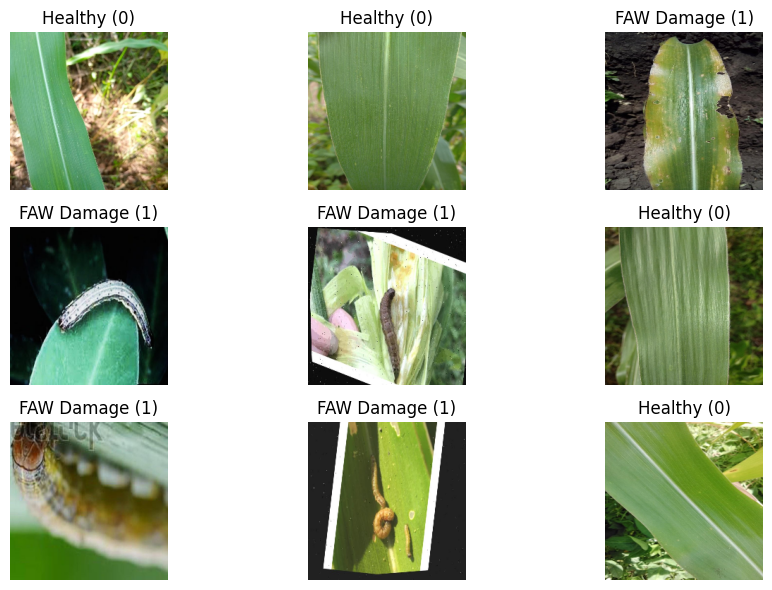

In [21]:
class_names = ["Healthy (0)", "FAW Damage (1)"]

plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()

### 5.5 Data Augmentation

In [22]:
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
], name="data_augmentation")



### 5.6 Handling Class Imbalance

In [23]:
# Count images per class
class_counts = {
    folder: len(os.listdir(os.path.join(base_dir, folder)))
    for folder in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, folder))
}

print("Image count per class:", class_counts)

# Prepare for compute_class_weight
classes = np.array(sorted([int(c) for c in class_counts.keys()]))
y = np.hstack([[c] * class_counts[str(c)] for c in classes])

# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

print("Computed class weights:", class_weights)

Image count per class: {'1': 1882, '0': 1107}
Computed class weights: {np.int64(0): np.float64(1.3500451671183378), np.int64(1): np.float64(0.7941020191285866)}


### 5.7 Verification of Preprocessing & Augmentation

In [24]:
# Verifying Preprocessing
for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape)
    print("Pixel range:", tf.reduce_min(images).numpy(), "to", tf.reduce_max(images).numpy())

Batch shape: (32, 224, 224, 3)
Pixel range: 0.0 to 1.0


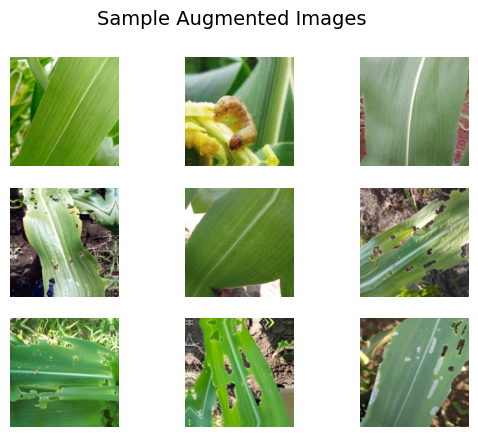

In [25]:
# Verifying Data Augmentation
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)

    # Plot 9 samples from the batch
    for i in range(min(9, len(augmented_images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy())
        plt.axis("off")
    plt.suptitle("Sample Augmented Images", fontsize=14)
plt.show()

## **6.0 MULTI-MODEL AND SINGLE MODEL TRAINING & EVALUATION**

### 6.1 Training Baseline Models

In [26]:
# Loading Pretrained Base Models
def get_base_model(name):
    """Return pretrained base model and its preprocess function."""
    if name == "MobileNetV2":
        return (
            MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
            mobilenet_pre
        )
    elif name == "EfficientNetB0":
        return (
            EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
            efficientnet_pre
        )
    elif name == "ResNet50":
        return (
            ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
            resnet_pre
        )
    elif name == "DenseNet121":
        return (
            DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3)),
            densenet_pre
        )
    else:
        raise ValueError(f"Unknown model name: {name}")

In [27]:
# Building & Compiling model
def build_model(base_model, preprocess_input):
    base_model.trainable = False  # Freeze convolutional layers

    inputs = layers.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)              #reuse augmentation pipeline
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [28]:
# Training only the DenseNet121 model
MODEL_NAME = "DenseNet121"
results = {}

print(f"\nTraining model: {MODEL_NAME}")

# Load base model and preprocessing function
base_model, preprocess_input = get_base_model(MODEL_NAME)
model = build_model(base_model, preprocess_input)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{MODEL_NAME}_baseline_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Fit model with class weights
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# Evaluate on test set
y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend((preds > 0.5).astype(int).flatten())

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
ap = average_precision_score(y_true, y_pred)

print(f"\nResults for {MODEL_NAME}:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Average Precision (AP): {ap:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Store results
results[MODEL_NAME] = {
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1_score": f1,
    "average_precision": ap
}
# Save the final trained model for this architecture
model.save(f"{MODEL_NAME}_baseline_final.keras")

print(f"\n{MODEL_NAME} model has been trained and evaluated successfully!")


Training model: DenseNet121
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4744 - loss: 0.7156
Epoch 1: val_accuracy improved from -inf to 0.49107, saving model to DenseNet121_baseline_best.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 331ms/step - accuracy: 0.4746 - loss: 0.7155 - val_accuracy: 0.4911 - val_loss: 0.6924
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5075 - loss: 0.7024
Epoch 2: val_accuracy improved from 0.49107 to 0.66295, saving model to DenseNet121_baseline_best.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 232ms/step - accuracy: 0.5077 - loss: 0.7023 - val_accuracy: 0.6629 - val_loss: 0.6830
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5370 - loss: 0.6898
Epoch 3: val_accuracy improved from 0.66295 to 0.67857, saving model to DenseNet121_baseline_best.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.5368 - loss: 0.6900 - val_accuracy: 0.6786 - val_loss: 0.6779

### 6.2 Evaluation Metrics of Baseline Models

In [29]:
# Summary of Model Evaluation Metrics
print("Summary of Evaluation Metrics of all Baseline Models:")


# Print model results
metrics = results[MODEL_NAME]

print(f"{MODEL_NAME}:")
print(f"   F1-Score          : {metrics['f1_score']:.4f}")
print(f"   Accuracy          : {metrics['accuracy']:.4f}")
print(f"   Precision         : {metrics['precision']:.4f}")
print(f"   Recall            : {metrics['recall']:.4f}")
print(f"   Average Precision : {metrics['average_precision']:.4f}\n")



Summary of Evaluation Metrics of all Baseline Models:
DenseNet121:
   F1-Score          : 0.8144
   Accuracy          : 0.7812
   Precision         : 0.8776
   Recall            : 0.7597
   Average Precision : 0.8185



In [30]:
#Loading best model from disk
best_model_instance = load_model(f"{MODEL_NAME}_baseline_final.keras")


## **7.0 Fine-Tuning DenseNet121 Model**

In [31]:
print(f"\nFine-tuning the model: {MODEL_NAME}")

base_model, preprocess_input = get_base_model(MODEL_NAME)
base_model.trainable = True  # Unfreeze the base model for fine-tuning


Fine-tuning the model: DenseNet121


In [32]:
# Build the full model with additional layers
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
fine_tune_model = models.Model(inputs, outputs)

In [33]:
# Compile the fine-tuning model with a lower learning rate
fine_tune_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [34]:
# Callbacks for fine-tuning
checkpoint_ft = tf.keras.callbacks.ModelCheckpoint(
    f"{MODEL_NAME}_finetuned_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop_ft = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,  # more patience for fine-tuning
    restore_best_weights=True
)

In [35]:
# Fit the model with class weights
history_ft = fine_tune_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint_ft, early_stop_ft],
    verbose=1
)

Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.6877 - loss: 0.5761
Epoch 1: val_accuracy improved from -inf to 0.37054, saving model to DenseNet121_finetuned_best.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 268s 716ms/step - accuracy: 0.6892 - loss: 0.5741 - val_accuracy: 0.3705 - val_loss: 0.8164
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9223 - loss: 0.2165
Epoch 2: val_accuracy did not improve from 0.37054
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 337ms/step - accuracy: 0.9224 - loss: 0.2162 - val_accuracy: 0.3705 - val_loss: 1.0988
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9530 - loss: 0.1301
Epoch 3: val_accuracy improved from 0.37054 to 0.39732, saving model to DenseNet121_finetuned_best.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 46s 392ms/step - accuracy: 0.9531 - loss: 0.1300 - val_accuracy: 0.3973 - val_loss: 1.1132
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9817 - loss: 0.0778
Epoch 4: val_accuracy did not improve from 

In [36]:
# Evaluate on test set
y_true_ft, y_pred_ft = [], []
for images, labels in test_ds:
    preds = fine_tune_model.predict(images, verbose=0)
    y_true_ft.extend(labels.numpy().astype(int))
    y_pred_ft.extend((preds > 0.5).astype(int).flatten())

In [37]:
# Compute metrics
acc_ft = accuracy_score(y_true_ft, y_pred_ft)
prec_ft = precision_score(y_true_ft, y_pred_ft)
rec_ft = recall_score(y_true_ft, y_pred_ft)
f1_ft = f1_score(y_true_ft, y_pred_ft)
ap_ft = average_precision_score(y_true_ft, y_pred_ft)

## **8.0 Evaluation of Final Tuned Model**

In [38]:
# Display metrics
print(f"\nFine-Tuned Model Results ({MODEL_NAME}):")
print(f"Accuracy          : {acc_ft:.4f}")
print(f"Precision         : {prec_ft:.4f}")
print(f"Recall            : {rec_ft:.4f}")
print(f"F1-Score          : {f1_ft:.4f}")
print(f"Average Precision : {ap_ft:.4f}")
print("\nClassification Report:\n", classification_report(y_true_ft, y_pred_ft))
print("Confusion Matrix:\n", confusion_matrix(y_true_ft, y_pred_ft))


Fine-Tuned Model Results (DenseNet121):
Accuracy          : 0.9710
Precision         : 1.0000
Recall            : 0.9541
F1-Score          : 0.9765
Average Precision : 0.9831

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       165
           1       1.00      0.95      0.98       283

    accuracy                           0.97       448
   macro avg       0.96      0.98      0.97       448
weighted avg       0.97      0.97      0.97       448

Confusion Matrix:
 [[165   0]
 [ 13 270]]


/tmp/ipython-input-2153161613.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")


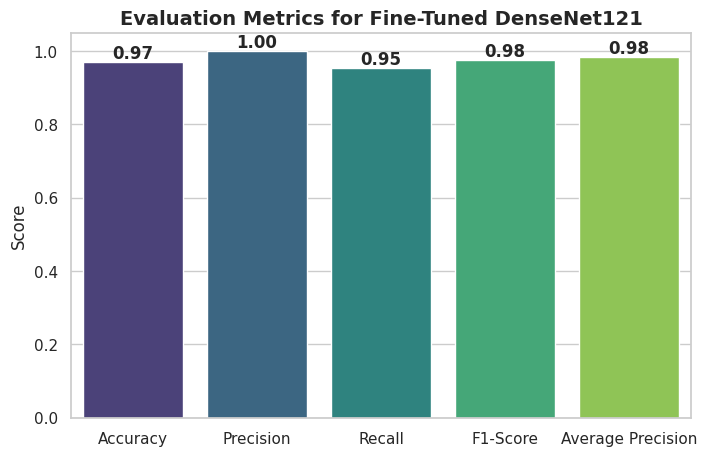

In [39]:
# Barplot of Metrics
metrics = {
    "Accuracy": acc_ft,
    "Precision": prec_ft,
    "Recall": rec_ft,
    "F1-Score": f1_ft,
    "Average Precision": ap_ft
}

sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
# Use metrics.keys() for x and metrics.values() for y
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")

# Iterate through values using metrics.values()
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

plt.ylim(0, 1.05)
plt.title(f"Evaluation Metrics for Fine-Tuned {MODEL_NAME}", fontsize=14, fontweight='bold')
plt.ylabel("Score")
plt.show()

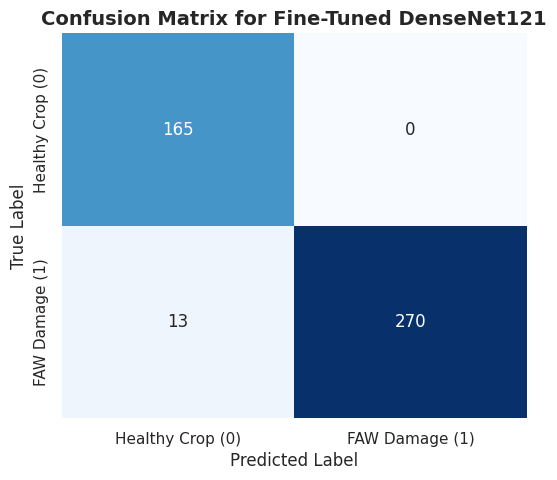

In [40]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_true_ft, y_pred_ft)
class_names = ['Healthy Crop (0)', 'FAW Damage (1)']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"Confusion Matrix for Fine-Tuned {MODEL_NAME}", fontsize=14, fontweight='bold')
plt.show()

## **9.0 Saving the Final Tuned Model**

In [41]:
# Save the fine-tuned model in Keras format
fine_tune_model.save(f"{MODEL_NAME}_finetuned_final.keras")
print(f"Fine-tuned Keras model saved as {MODEL_NAME}_finetuned_final.keras")

Fine-tuned Keras model saved as DenseNet121_finetuned_final.keras


In [9]:
# Define ONNX file name
onnx_model_path = f"DenseNet121_finetuned_final.onnx"

model = load_model(f"DenseNet121_finetuned_final.keras")
# Convert TensorFlow/Keras model to ONNX
# Using opset 11 for compatibility with ONNX 1.17.0 and to address potential padding issues
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)

# Save the ONNX model
onnx.save(onnx_model, onnx_model_path)
print(f"ONNX model saved as {onnx_model_path}")

ONNX model saved as DenseNet121_finetuned_final.onnx
